# Visualizing the data captured
This script will allow you to visualise the data you captured (or were given). At the end you will have a 1D plot (in other words the Range FFT) giving you the change in frequencies in the x axis and the power at which those frequencies are on the y axis. The change (or delta) in frequencies will enable you to estimate the range at which the object was from the radar, whereas the power allows you to understand the strength of the reflector. The strength can be impacted by many things such as the material (something like metal will reflect much more of the signal than something like plastic), the size, and shape of the reflector!


In [4]:

import numpy as np
import matplotlib.pyplot as plt
import os
import scipy
import scipy.io as sio
import processing.utility as utility
import processing.save_adc_data as sd

## Finding your way to the data
This part allow you to specify where all the **data** is located in your file system, relative to where this file (visualize_data.ipynb) is saved.
* *filename* must correspond to the name of the **experiment** you made (it is the same as the one you had to setup in the config file)
* *capture_data_dir* must correspond to the folder were you stored the **raw data** captured by the radar (aka the *.bin file)
* *json_filename* correspond to the the json file that we provide for you, it describes the paramters that you captured the data, such as number of frames, number of transmitters, number of receivers, number of ADC samples, etc. 
* *config_lua_script* is the configuration lua script (same as capture_data.ipynb)

**IMPORTANT NOTE** 
If you decide to change something about the chirp parameters (primarily number of Tx, number of Rx, or ADC samples) then you must do some extra edits below to reformat the data accordingly. Otherwise leave the defaults.




In [5]:
# TODO: Put the *name* of your .bin file here (excluding the .bin)
filename = r"1"
# TODO: Put the *path* to the project folder
home_dir = r"Y:\com304-project"
# TODO: Put the path (relative to home_dir) of the captured data folder
capture_data_dir = r"record"
# TODO: Put the path (relative to home_dir) and name of the JSON files (exlude the .setup.json and .mmwave.json)
json_filename = r"scripts/chirp1"
# TODO: Put the relative path to the lua scripts for configuration assuming it in is the home dir(ex. scripts/1843_config.lua)
config_lua_script = r'scripts/1843_config.lua' 

# this function reads the parameters from your lua config file (look at this function to see how it expects your config file to be formatted)
num_rx, num_tx, samples_per_chirp, periodicity, num_frames, chirp_loops, data_rate, freq_plot_len, range_plot_len = utility.read_radar_params(os.path.join(home_dir, config_lua_script)) 
adc_samples = samples_per_chirp

######### only edit here if you want to change the chirp paramters!!!! #############
tx_en = '0x7' # HEX enable (1 for on, 0 for off)
rx_en = '0xF' # HEX enable (1 for on, 0 for off)

args = [num_tx, num_rx, adc_samples, chirp_loops, tx_en, rx_en]

This cells calls to another script that you have called save_adc_data, located in the **processing** folder. What this script does it reformating the data, which is a binary file, to a more understandable format which it a .mat {}

In [7]:
############################# Reformat the Data #############################
if not os.path.exists(os.path.join(home_dir, "rdc_" + filename + '.mat')):
    sd.save_adc_data(filename, home_dir, capture_data_dir, json_filename, args)

Y:\com304-project\record\raw_1
Y:\com304-project\record\rdc_1
Input ADC data parameters:
    dataFmt: 1
    iqSwap: 0
    chanInterleave: 1
    numChirpsPerFrame: 3
    adcBits: 2
    numRxChan: 4
    numAdcSamples: 512
Radarcube parameters:
    iqSwap: 0
    radarCubeFmt: 1
    numDopplerChirps: 1
    numRxChan: 4
    numTxChan: 3
    numRangeBins: 512.0


In [8]:
################################# load data #################################
bin_data = sio.loadmat(os.path.join(home_dir, capture_data_dir, "rdc_" + filename + ".mat"))
raw_data = np.array(bin_data['data_raw'])

print("You captured %d frames, for %d TX, %d Rx, and %d adc samples" % raw_data.shape)

You captured 20 frames, for 3 TX, 4 Rx, and 512 adc samples


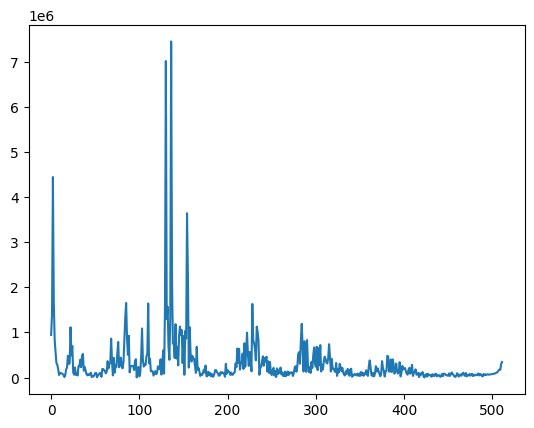

In [9]:
############################### process data! ################################
# Range FFT
rfft = scipy.fft.fft(raw_data, axis=3)

# Plot the Range FFT
plt.plot(abs(np.squeeze(np.sum(rfft, axis=(0,2,1)))))


In [18]:
print(np.shape(raw_data))

(20, 3, 4, 512)


In [41]:
lm = 3e8/77e9 # define lambda for the antenna spacing

# rx_pos = np.arange(1, 5, dtype=float) * -lm/2
# rx_pos = rx_pos - rx_pos[0]
# ant_pos = rx_pos

# define rx pos
rx_pos = np.arange(1, 5, dtype=float)
rx_pos = rx_pos * -lm/2
rx_pos = rx_pos - rx_pos[0]

# define tx offsets
x_pos = np.arange(1, 4, dtype=float)
x_pos = x_pos * lm
x_pos = x_pos - x_pos[0]

# define virtual ant positions
ant_pos = np.reshape(np.array([rx_pos + x_pos[i] for i in range(len(x_pos))]), (-1,1))
print(ant_pos/lm)

[[ 0.00000000e+00]
 [-5.00000000e-01]
 [-1.00000000e+00]
 [-1.50000000e+00]
 [ 1.00000000e+00]
 [ 5.00000000e-01]
 [-1.11311423e-16]
 [-5.00000000e-01]
 [ 2.00000000e+00]
 [ 1.50000000e+00]
 [ 1.00000000e+00]
 [ 5.00000000e-01]]


In [46]:
def beamform_1d(beat_freq_data, theta_s, theta_e, theta_res, locs):
    """
    Performs 1D beamforming along the azimuth (horizontal) dimension, this results in a bird eye view image.

    Paramters:
    - beat_freq_data: beat data AKA the range FFT (size: num TX * num RX, num ADC samples)
    - theta_s: first angle that you want to start computing 
    - theta_e: last angle that you want to compute 
    - theta_res: resolution of the angles you want to compute
    - locs: antenna locations

    Returns:
    - sph_pwr: beamformed result
    - theta: the array of the angles computed
    """
    # Generate arrays for theta 
    theta = np.arange(
        theta_s * (np.pi/180),
        theta_e * (np.pi/180),
        np.pi/180)
    N_theta = len(theta)

    # Initialize arrays for spherical power
    sph_pwr = np.zeros((N_theta, adc_samples), dtype=complex)

    # print("Running this many iterations: %d " % (N_theta))

    ######################## BF Calculations ###########################3
    for kt in range(N_theta):
        bf_vector = np.reshape(np.exp(1j * (2 * np.pi * (locs * np.cos(theta[kt]))/lm) ), locs.shape)

        VecRFI = np.squeeze(np.repeat(bf_vector[:, np.newaxis], adc_samples, axis=1)) # make sure the size of the steering vector is the same as the data

        sph_pwr[kt, :] = np.squeeze(np.sum(np.multiply(np.squeeze(beat_freq_data), VecRFI), axis=(0)))        

        # print("Processed angle (%.2f)" % (theta[kt]*180/np.pi), end='\r')
    return sph_pwr, theta

(12, 512)
CPU times: total: 93.8 ms
Wall time: 90.1 ms


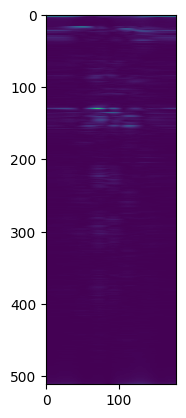

In [58]:
%%time
###################### 2D Array ###########################
# num_x_stp, num_z_stp, num_tx, num_rx, adc_samples = raw_data.shape
# X = raw_data[num_x_stp//2,num_z_stp//2,:,:,:]

# X = raw_data[0,0,:,:]

# one capture sends back 20 frames but 1 frame is actually enough
X = np.reshape(raw_data[0,:,:,:], (12, 512))
# X = np.reshape(np.sum(raw_data, axis=0), (12, 512))

beat_freq = scipy.fft.fft(X, axis=-1)
beat_freq = np.reshape(beat_freq, (-1, adc_samples))

theta_s, theta_e = 0, 180
theta_res = 1
print(beat_freq.shape)
bf_output, theta = beamform_1d(beat_freq, theta_s, theta_e, theta_res, ant_pos)


# plot_lim_y = [10,200]
# plot_lim_x = [0 - theta_s,179 - theta_s]
# to_plot = bf_output
# to_plot = to_plot[plot_lim_x[0]:plot_lim_x[1],plot_lim_y[0]:plot_lim_y[1]]
# to_plot = to_plot/np.max(np.reshape(to_plot,(1,-1)))
# to_plot = to_plot[:,::-1]
# plt.imshow(abs((to_plot).T), extent=[theta[plot_lim_x[0]]-np.pi/2, theta[plot_lim_x[1]]-np.pi/2,plot_lim_y[0] * 0.041763,plot_lim_y[1] * 0.041763],cmap = 'jet',  vmin=0, vmax=1.2) # this is giving the y axis in meters, and x axis in angles 
plt.imshow(abs(bf_output).T)